## 使用中阶API来实现线性回归



In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)


In [ ]:
### 数据准备

导入python库

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers

print(tf.__version__)

2.1.0


In [3]:
# 生成样本数据

n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

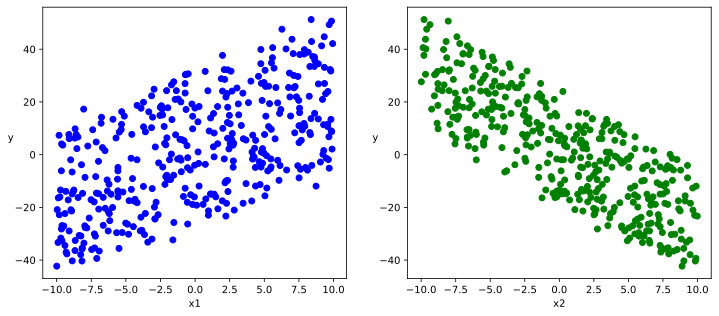

In [4]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()



In [ ]:
# 建立数据管道迭代器
# 这样可以实现mini_batch 

# 这里使用python中的数据生成yield工具
def data_iter(features,labels,batch_size=8):
    # 获取样本数据的大小
    num_examples = len(features)
    # 将样本数据进行标号
    indices = list(range(num_examples))
    # 对样本数据进行随机洗牌
    np.random.shuffle(indices)

    # 开始每次取出batch_size个数据
    for i in range(0,num_examples,batch_size):
        # 获得随机个数据
        indexs = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(X,indexs),tf.gather(Y,indexs)

In [7]:
#构建管道数据

ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

# ds = tf.data.Dataset.from_tensor_slices((X,Y)).shuffle(buffer_size=100).batch(10).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# 定义模型
model = layers.Dense(units=1)
model.build(input_shape=(2,)) #用build方法创建variables
model.loss_func = losses.mean_squared_error # 损失函数
model.optimizer = optimizers.SGD(learning_rate=0.001) #定义优化器

In [11]:
# 训练模型
@tf.function
def train_step(model,features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]),
        tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss



In [10]:
# test train_step
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)


<tf.Tensor: shape=(), dtype=float32, numpy=497.55634>

In [12]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features,labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50 ==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])

In [13]:
# 开始训练模型

train_model(model,epochs = 200)

================================================================================18:59:27
epoch = 50 loss =  5.73399305
w = [[1.99384952]
 [-2.98214]]
b = [2.78558087]
================================================================================18:59:28
epoch = 100 loss =  2.70352888
w = [[1.9972645]
 [-2.98404]]
b = [2.83885431]
================================================================================18:59:29
epoch = 150 loss =  3.11538124
w = [[1.98507595]
 [-2.97857213]]
b = [2.83742905]
================================================================================18:59:31
epoch = 200 loss =  1.97604966
w = [[1.99656248]
 [-2.96587944]]
b = [2.83846331]


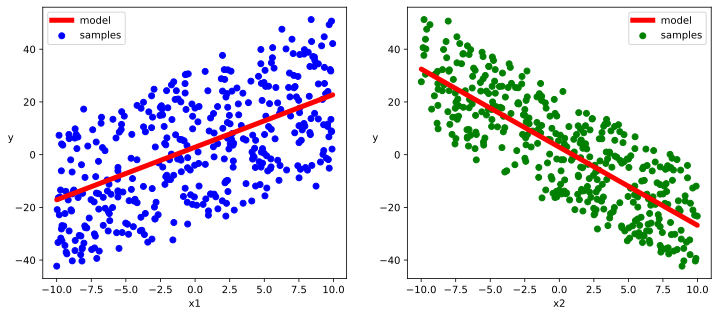

In [14]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()